# <span style="color:#2E86C1;">Projet de Détection d’Intrusions Réseau</span>

---

## <span style="color:#2874A6;">Présentation</span>

Ce projet consiste à créer un programme capable de détecter automatiquement quand un réseau informatique est attaqué ou fonctionne normalement.  
Un réseau, c’est comme un ensemble d’ordinateurs et de machines qui communiquent entre eux. Parfois, ce réseau peut être ciblé par des attaques, comme des virus ou des hackers, qui veulent perturber ou voler des informations.

---

## <span style="color:#2874A6;">Utilité</span>

Pour protéger un réseau, il faut surveiller tout ce qui se passe dessus.  
Mais les données générées sont énormes, et tout analyser en détail peut être très long et coûteux en ressources (ordinateur, temps).  
Alors, on cherche à faire en sorte que l’ordinateur puisse repérer rapidement les moments où il y a quelque chose d’inhabituel — comme une attaque — pour concentrer les efforts d’analyse uniquement à ces moments-là.

---

## <span style="color:#2874A6;">Principe</span>

On utilise des données qui décrivent le trafic réseau (tout ce qui circule entre les machines) et on apprend à un programme à reconnaître les « bons » comportements et les comportements suspects.  
Pour cela, on donne au programme beaucoup d’exemples de trafic normal et d’attaques, pour qu’il comprenne les différences.

---

## <span style="color:#2874A6;">Outils</span>

On utilise une méthode appelée **Random Forest**, un algorithme d’intelligence artificielle qui est très efficace pour classer les données en différentes catégories (ici : normal ou attaque).  
Il regarde les informations disponibles, analyse les modèles, puis décide si le trafic est suspect ou pas.

---

## <span style="color:#2874A6;">Deroulement</span>

1. **On charge les données** : les exemples de trafic réseau, avec leurs étiquettes (normal ou attaque).  
2. **On prépare les données** : on transforme les données pour que l’ordinateur puisse bien les comprendre.  
3. **On entraîne le modèle** : on donne au Random Forest les données d’entraînement pour qu’il apprenne.  
4. **On teste le modèle** : on vérifie comment il se débrouille avec de nouvelles données.  
5. **On regarde les résultats** : on évalue si le modèle détecte bien les attaques et évite les erreurs.

---

## <span style="color:#2874A6;">Objectif final</span>

Ce programme peut aider à protéger les réseaux en détectant rapidement des comportements suspects, ce qui permet d’agir plus vite et d’éviter des dégâts.  
En plus, il rend la surveillance plus efficace en ne s’attardant que sur ce qui semble anormal.

<h2 style="color:#2874A6;">Chargement et Exploration des Données</h2>

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import numpy as np

In [4]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [5]:
# Chargement des données
train_df = pd.read_csv('UNSW_NB15_training-set.csv')
test_df = pd.read_csv('UNSW_NB15_testing-set.csv')

In [6]:
print(f"Shape training set : {train_df.shape}")
print(f"Shape testing set : {test_df.shape}")

Shape training set : (82332, 45)
Shape testing set : (175341, 45)


In [7]:
# Concaténation optionnelle pour exploration
full_df = pd.concat([train_df, test_df], ignore_index=True)
print(f"Shape full dataset : {full_df.shape}")

Shape full dataset : (257673, 45)


In [8]:
# Aperçu des données
display(full_df.head())

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


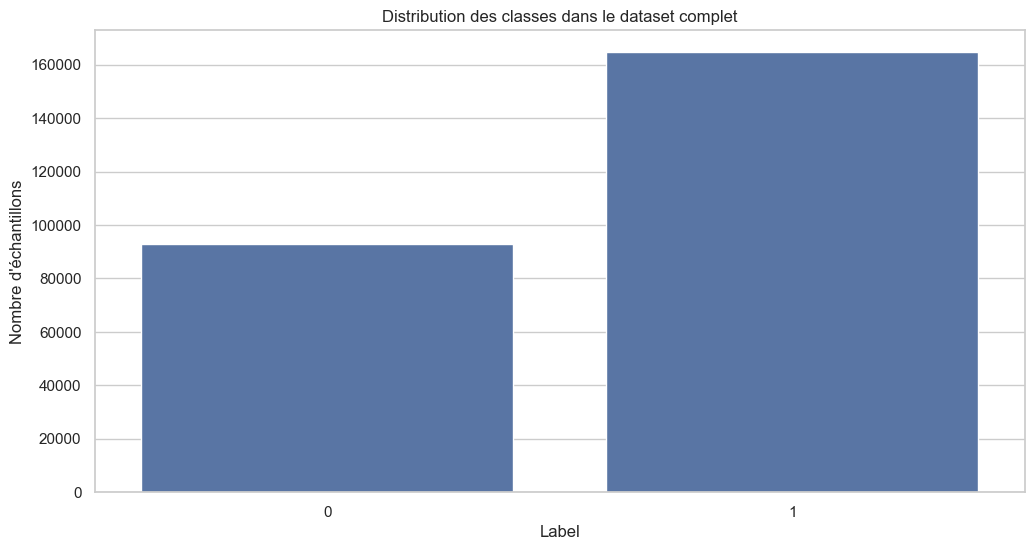

In [9]:
sns.countplot(x='label', data=full_df)
plt.title("Distribution des classes dans le dataset complet")
plt.xlabel("Label")
plt.ylabel("Nombre d'échantillons")
plt.show()

In [10]:
# Distribution des classes dans le dataset complet
print("\nDistribution des classes (0 = normal, 1 = attaque) dans l'ensemble complet :")
print(full_df['label'].value_counts())


Distribution des classes (0 = normal, 1 = attaque) dans l'ensemble complet :
label
1    164673
0     93000
Name: count, dtype: int64


<h2 style="color:#2874A6;">Prétraitement des Données</h2>

In [11]:
# colonnes catégorielles
categorical_cols = full_df.select_dtypes(include=['object']).columns.tolist()
print(f"Colonnes catégorielles : {categorical_cols}")

Colonnes catégorielles : ['proto', 'service', 'state', 'attack_cat']


In [12]:
# Encodage LabelEncoder
le = LabelEncoder()
for col in categorical_cols:
    full_df[col] = le.fit_transform(full_df[col])

In [13]:
# Séparation train/test :on reprend les splits officiels du kaggle
X_train = full_df.loc[:len(train_df)-1].drop('label', axis=1)
y_train = full_df.loc[:len(train_df)-1, 'label']

X_test = full_df.loc[len(train_df):].drop('label', axis=1)
y_test = full_df.loc[len(train_df):, 'label']

In [14]:
# Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Shape X_train_scaled : {X_train_scaled.shape}")
print(f"Shape X_test_scaled : {X_test_scaled.shape}")

Shape X_train_scaled : (82332, 44)
Shape X_test_scaled : (175341, 44)


<h2 style="color:#2874A6;">Modélisation - Random Forest Classifier</h2>

In [15]:
# Initialisation et entraînement
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

In [16]:
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [17]:
# Prédictions
y_pred = rf.predict(X_test_scaled)
y_proba = rf.predict_proba(X_test_scaled)[:,1]

In [ ]:
<h2 style="color:#2E86C1;">Évaluation et Interprétation des Résultats</h2>

In [18]:
# Rapport de classification
print("Rapport de classification :")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Attaque']))

Rapport de classification :
              precision    recall  f1-score   support

      Normal       0.87      1.00      0.93     56000
     Attaque       1.00      0.93      0.96    119341

    accuracy                           0.95    175341
   macro avg       0.93      0.96      0.95    175341
weighted avg       0.96      0.95      0.95    175341



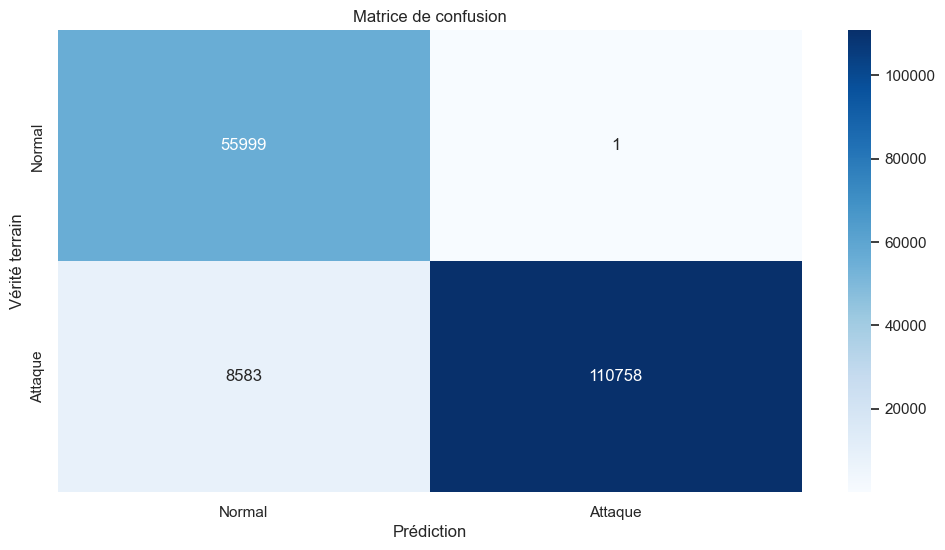

In [19]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attaque'], yticklabels=['Normal', 'Attaque'])
plt.title("Matrice de confusion")
plt.xlabel("Prédiction")
plt.ylabel("Vérité terrain")
plt.show()

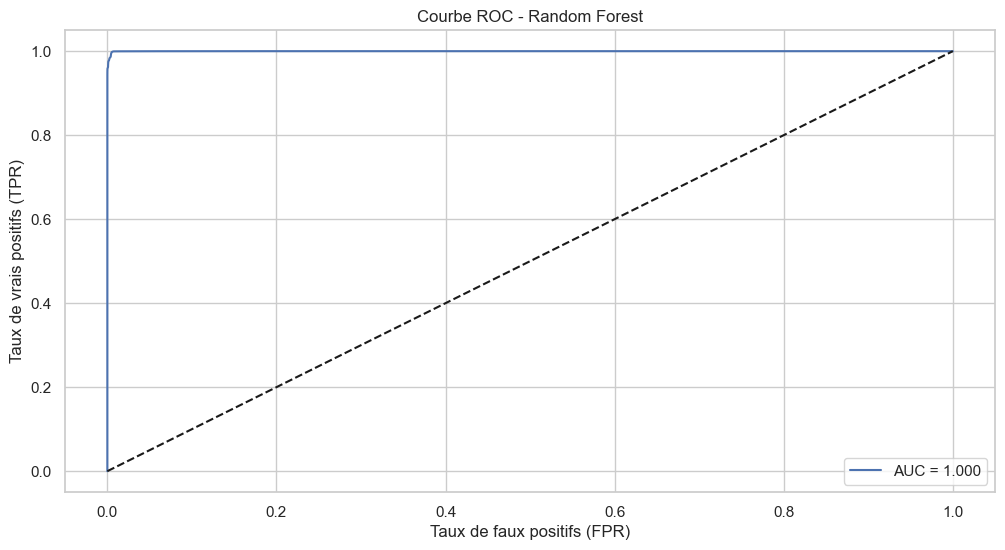

In [20]:
# Courbe ROC
roc_auc = roc_auc_score(y_test, y_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC - Random Forest')
plt.legend(loc='lower right')
plt.show()

In [23]:
print(f"score AUC : {roc_auc:.3f}")

score AUC : 1.000


Le modèle Random Forest atteint un score AUC de : 1.000, ce qui indique une bonne capacité à distinguer les attaques du trafic normal.

La matrice de confusion montre que le modèle détecte correctement la majorité des attaques, avec un faible taux de faux positifs.

Ce compromis peut être ajusté en fonction des besoins opérationnels.

<h2 style="color:#2874A6;">Analyse des Variables Importantes</h2>

In [25]:
importances = rf.feature_importances_
features = X_train.columns

feat_imp_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False).head(20)

/var/folders/bx/204yq0ms2g9b_nsks2zdj9500000gp/T/ipykernel_38471/422223384.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')


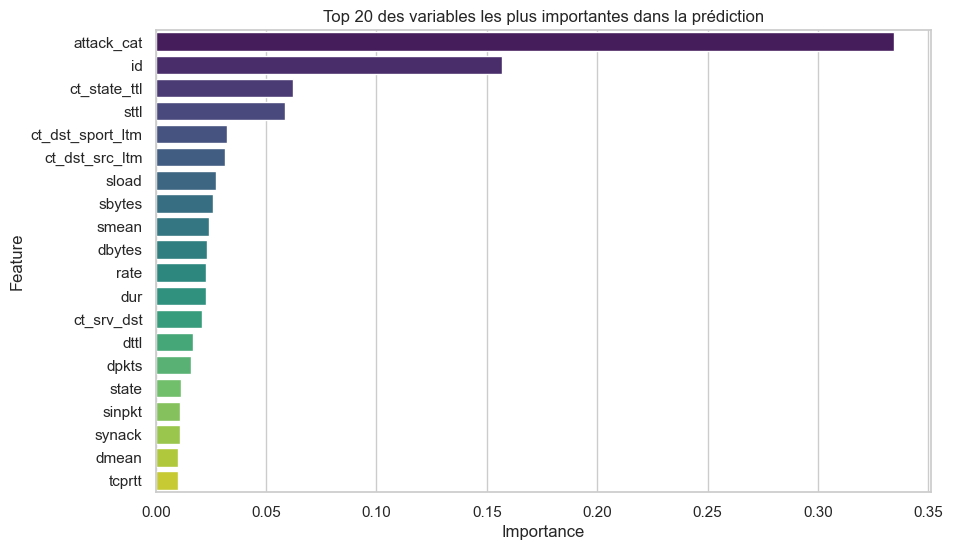

In [26]:
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')
plt.title("Top 20 des variables les plus importantes dans la prédiction")
plt.show()

#### Ces variables sont les plus déterminantes pour le modèle dans la différenciation entre trafic normal et attaque.

<h3 style="color:#2E86C1;">Conclusion</h3>

#### Ce notebook a démontré comment exploiter le dataset UNSW-NB15 avec un modèle Random Forest pour détecter des intrusions réseau.
#### Cette approche permet de classifier avec précision le trafic normal et malveillant, offrant un outil précieux pour la surveillance et la sécurité des réseaux informatiques.
#### Pour aller plus loin, il serait pertinent d’explorer d’autres modèles, d’affiner les hyperparamètres, ou de tester des méthodes non supervisées pour améliorer la détection d’anomalies.